# Investigating Misclassifications (cont...)

In [4]:
import os
os.chdir('C:\Users\Lundi\Documents\Programming\Python\Kaggle\Digits')
#os.chdir('/Users/alexsutherland/Documents/Programming/Python/Kaggle/Digits')
import time

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.svm as skl_svm
import sklearn.cross_validation as skl_cv
from sklearn.grid_search import GridSearchCV

In [2]:
misclassified_crosstab_df = pd.read_csv('Data/misclassified_crosstab.csv')

In [3]:
misclassified_crosstab_df

,Actual,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,2,2,0,2,0,3,1
1,1,0,0,4,3,1,0,2,3,4,2
2,2,6,4,0,3,7,0,4,11,7,1
3,3,1,3,10,0,0,11,4,2,7,3
4,4,2,1,4,0,0,0,5,2,0,16
5,5,2,1,2,13,0,0,10,0,8,6
6,6,9,0,0,0,6,9,0,0,1,0
7,7,3,8,12,3,6,1,1,0,1,13
8,8,2,7,9,15,3,13,2,3,0,8
9,9,6,3,4,3,18,3,1,11,7,0


In order to make sense of this, I need a way to re-classify after the first layer. Let's see if the prediction probabilities differ between correctly classified 8s and incorrectly classified 8s

## Classification probabilites for 8s (correct vs. incorrect)

First, I need to load the data:

In [6]:
digit_data = pd.read_csv('Data/train.csv')

X = digit_data.ix[:,1:digit_data.shape[1]]
y = digit_data['label']

X_subset = X.ix[0:10000,:]
y_subset = y.ix[0:10000]

Next, I will generate a prediction for each element in a subset of the full data. Furthermore, I need the prediction probabilities for these same samples. Therefore, I will run a custom cross-validation to get both of these:

In [61]:
col_names = ['Actual','Predicted']
col_names.extend(map(lambda x: str(x), xrange(10)))

y_result_df = pd.DataFrame({'Actual': y_subset.copy(), 'Predicted': -1}, columns=col_names)
y_result_df.head()

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9
0,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
svc_poly_clf = skl_svm.SVC(
    C=2.8e-5, 
    degree=2, 
    gamma='auto', 
    kernel='poly', 
    tol=0.001,
    probability=True
)

for train_indexes, test_indexes in skl_cv.KFold(n = X_subset.shape[0], n_folds=7):
    X_train = X_subset.ix[train_indexes, :]
    X_test = X_subset.ix[test_indexes, :]
    y_train = y_subset.ix[train_indexes]
    y_test = y_subset.ix[test_indexes]
    
    svc_poly_clf.fit(X_train, y_train)
    y_result_df.ix[X_test.index, 'Predicted'] = svc_poly_clf.predict(X_test)
    y_result_df.ix[X_test.index, map(lambda x: str(x), xrange(10))] = svc_poly_clf.predict_proba(X_test)


In [64]:
y_result_df.head()

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9
0,1,1,0.000859017,0.969073,0.00481337,0.0022615,0.00100061,0.00253442,0.0020909,0.000501096,0.0164469,0.000419522
1,0,0,1,1.23473e-08,5.58431e-08,2.11873e-08,1.22493e-08,3.48684e-08,7.14132e-08,1.63043e-08,2.76493e-08,4.55019e-08
2,1,1,7.27109e-05,0.989237,0.00199248,0.000265097,8.93205e-05,0.000352322,0.000300857,0.00178903,0.00570931,0.000191948
3,4,4,0.0566744,0.0401362,0.088132,0.0311805,0.353236,0.0703145,0.132901,0.0969923,0.0191433,0.11129
4,0,0,1,1.23705e-08,8.63034e-08,2.20336e-08,1.22683e-08,4.1412e-08,4.31711e-08,1.60526e-08,3.25285e-08,2.75805e-08


Next, I will make a DataFrame with the actual and predictive classes, along with a column for if the prediction was correct:

In [68]:
y_result_df['is_correct'] = -1
y_result_df['is_correct'] = y_result_df.apply(lambda row: row['Actual'] == row['Predicted'],axis=1)
y_result_df.head(2)

,Actual,Predicted,0,1,2,3,4,5,6,7,8,9,is_correct
0,1,1,0.000859017,0.969073,0.00481337,0.0022615,0.00100061,0.00253442,0.0020909,0.000501096,0.0164469,0.000419522,True
1,0,0,1,1.23473e-08,5.58431e-08,2.11873e-08,1.22493e-08,3.48684e-08,7.14132e-08,1.63043e-08,2.76493e-08,4.55019e-08,True


Let's write this to disk:

In [69]:
y_result_df.to_csv('Data/svc_classification_data.csv')

I will now limit this to only rows that were actually 8:

In [124]:
y_result_8s_df = y_result_df.ix[y_result_df['Actual'] == 8,:].drop(['Actual'], axis=1)
y_result_8s_df.head(2)

,Predicted,0,1,2,3,4,5,6,7,8,9,is_correct
10,8,0.00010794,4.85256e-08,4.14134e-06,6.59128e-05,6.66448e-06,3.20952e-05,8.91284e-08,9.80968e-07,0.999763,1.9251e-05,True
20,8,0.000133185,0.000122251,0.000247017,0.00590951,6.51265e-05,0.00131185,3.55707e-05,2.63326e-05,0.991203,0.000946115,True


Converting everything to numeric

In [125]:
y_result_8s_df[['0','1','2','3','4','5','6','7','8','9']] = y_result_8s_df[['0','1','2','3','4','5','6','7','8','9']].apply(lambda c: pd.to_numeric(c), axis=0)

Now let's do some analysis based on if the actual 8 was classified correctly or not:

In [126]:
y_result_8s_grouped_describe = y_result_8s_df.groupby(['is_correct'])[['0','1','2','3','4','5','6','7','8','9']].describe()
y_result_8s_grouped_describe.applymap(lambda x: round(x,3))

0        1        2        3        4        5  \
is_correct                                                               
False      count   59.000   59.000   59.000   59.000   59.000   59.000   
           mean     0.039    0.104    0.115    0.180    0.034    0.127   
           std      0.079    0.209    0.205    0.260    0.071    0.166   
           min      0.000    0.000    0.000    0.000    0.000    0.000   
           25%      0.003    0.004    0.010    0.018    0.004    0.010   
           50%      0.007    0.013    0.030    0.050    0.009    0.050   
           75%      0.031    0.060    0.094    0.235    0.027    0.173   
           max      0.370    0.807    0.811    0.918    0.417    0.698   
True       count  891.000  891.000  891.000  891.000  891.000  891.000   
           mean     0.002    0.005    0.008    0.014    0.002    0.010   
           std      0.007    0.025    0.028    0.044    0.008    0.036   
           min      0.000    0.000    0.000    0.000    0.000    0.000   
           25%      0.000    0.000    0.000    0.000    0.000    0.000   
           50%      0.000    0.000    0.000    0.001    0.000    0.000   
           75%      0.001    0.001    0.004    0.008    0.000    0.002   
           max      0.088    0.334    0.377    0.475    0.084    0.403   

                        6        7        8        9  
is_correct                                            
False      count   59.000   59.000   59.000   59.000  
           mean     0.037    0.041    0.219    0.103  
           std      0.084    0.084    0.139    0.199  
           min      0.000    0.000    0.014    0.001  
           25%      0.003    0.003    0.090    0.007  
           50%      0.008    0.007    0.201    0.025  
           75%      0.022    0.028    0.306    0.088  
           max      0.501    0.400    0.515    0.982  
True       count  891.000  891.000  891.000  891.000  
           mean     0.004    0.003    0.945    0.007  
           std      0.020    0.016    0.118    0.028  
           min      0.000    0.000    0.210    0.000  
           25%      0.000    0.000    0.963    0.000  
           50%      0.000    0.000    0.995    0.000  
           75%      0.001    0.000    1.000    0.002  
           max      0.257    0.250    1.000    0.367

## Plotting differences between correct and incorrect prediction probabilities

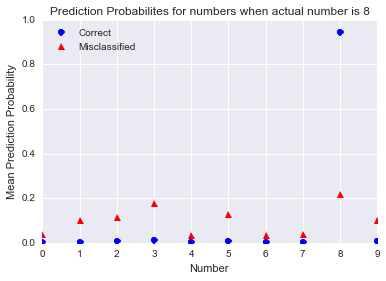

In [120]:
plt.plot(xrange(10), y_result_8s_grouped_describe.ix[(True,'mean')], 'bo')
plt.plot(xrange(10), y_result_8s_grouped_describe.ix[(False,'mean')], 'r^')
plt.legend(['Correct', 'Misclassified'], loc='upper left')
ax = plt.gca()
ax.set_xlabel('Number')
ax.set_ylabel('Mean Prediction Probability')
ax.set_title('Prediction Probabilites for numbers when actual number is 8')

## Plotting distribution of prediction probs of 8 for correct and misclassified

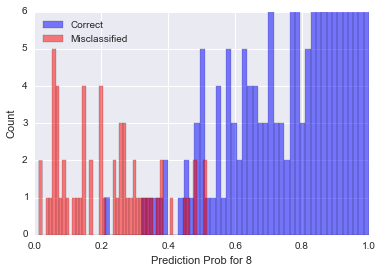

In [143]:
plt.hist(y_result_8s_df.ix[y_result_8s_df['is_correct'],'8'].values, bins=50, alpha=0.5, color='b');
plt.hist(y_result_8s_df.ix[~y_result_8s_df['is_correct'],'8'].values, bins=50, alpha=0.5, color='r');
ax = plt.gca();
ax.set_ylim([0,6]);
ax.set_xlabel('Prediction Prob for 8')
ax.set_ylabel('Count')
ax.legend(['Correct','Misclassified'], loc='upper left')

This shows that a cut-off near a prediction probability of ~0.4 will capture most of the incorrectly classified 8s. The remainder can undergo further analysis